In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

In [2]:
import os
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:
images_path = "prepared_images"
labels_file = "C:/Users/kaust/.cache/kagglehub/datasets/hammadjavaid/6992-labeled-meme-images-dataset/versions/1/labels.csv"

data = pd.read_csv(labels_file)
data

,Unnamed: 0,image_name,text_ocr,text_corrected,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,very_positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,very_positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral
...,...,...,...,...,...
6987,6987,image_6988.jpg,Tuesday is Mardi Gras Wednesday is Valentine's...,Tuesday is Mardi Gras Wednesday is Valentine's...,neutral
6988,6988,image_6989.jpg,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,neutral
6989,6989,image_6990.png,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,positive
6990,6990,image_6991.jpg,When I VERY have time is a fantasy No one has ...,When I have time is a fantasy. no one has time...,very_positive


In [4]:
from datasets import Dataset

In [5]:
import datasets

In [6]:
import os
list_ds = []
for image_name, text in zip(data["image_name"], data["text_corrected"]):
    image_path = f"prepared_images/{str(image_name)}"
    if os.path.isfile(image_path):  # Проверяем, существует ли файл
        list_ds.append({
            "image": image_path,
            "text": str(text),
        })


dict_ds = {
    "image": [item["image"] for item in list_ds[:5000]],
    "text": [item["text"] for item in list_ds[:5000]],
}

dict_ds_empty = {
    "image": [item["image"] for item in list_ds[5000:5100]],
    "text": [item["text"] for item in list_ds[5000:5100]],
}

train_ds = datasets.Dataset.from_dict(dict_ds)
test_ds = datasets.Dataset.from_dict(dict_ds_empty)

In [7]:
test_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 100
})

In [8]:
train_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 5000
})

In [9]:
def transforms(example_batch):
    images = [Image.open(x).convert("RGB") for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [10]:
train_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 5000
})

In [11]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

In [12]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [13]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [14]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=6e-7,
    num_train_epochs=1,
    fp16=True,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=1200,
    save_strategy="steps",
    save_steps=1200,
    logging_steps=1200,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

c:\Users\kaust\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")


Using device: cuda


In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [17]:
!set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

To start training, simply call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) on the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) object.

In [18]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kuklinpavel2004 (kuklinpavel2004-innopolis-university). Use `wandb login --relogin` to force relogin


  0%|          | 0/1250 [00:00<?, ?it/s]

{'loss': 8.8652, 'grad_norm': 71.6337661743164, 'learning_rate': 2.592e-08, 'epoch': 0.96}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 8.12728500366211, 'eval_wer_score': 32.43904063957362, 'eval_runtime': 266.2887, 'eval_samples_per_second': 0.376, 'eval_steps_per_second': 0.188, 'epoch': 0.96}
{'train_runtime': 872.1677, 'train_samples_per_second': 5.733, 'train_steps_per_second': 1.433, 'train_loss': 8.841015600585937, 'epoch': 1.0}


TrainOutput(global_step=1250, training_loss=8.841015600585937, metrics={'train_runtime': 872.1677, 'train_samples_per_second': 5.733, 'train_steps_per_second': 1.433, 'total_flos': 2338413189120000.0, 'train_loss': 8.841015600585937, 'epoch': 1.0})

You should see the training loss drop smoothly as training progresses.

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

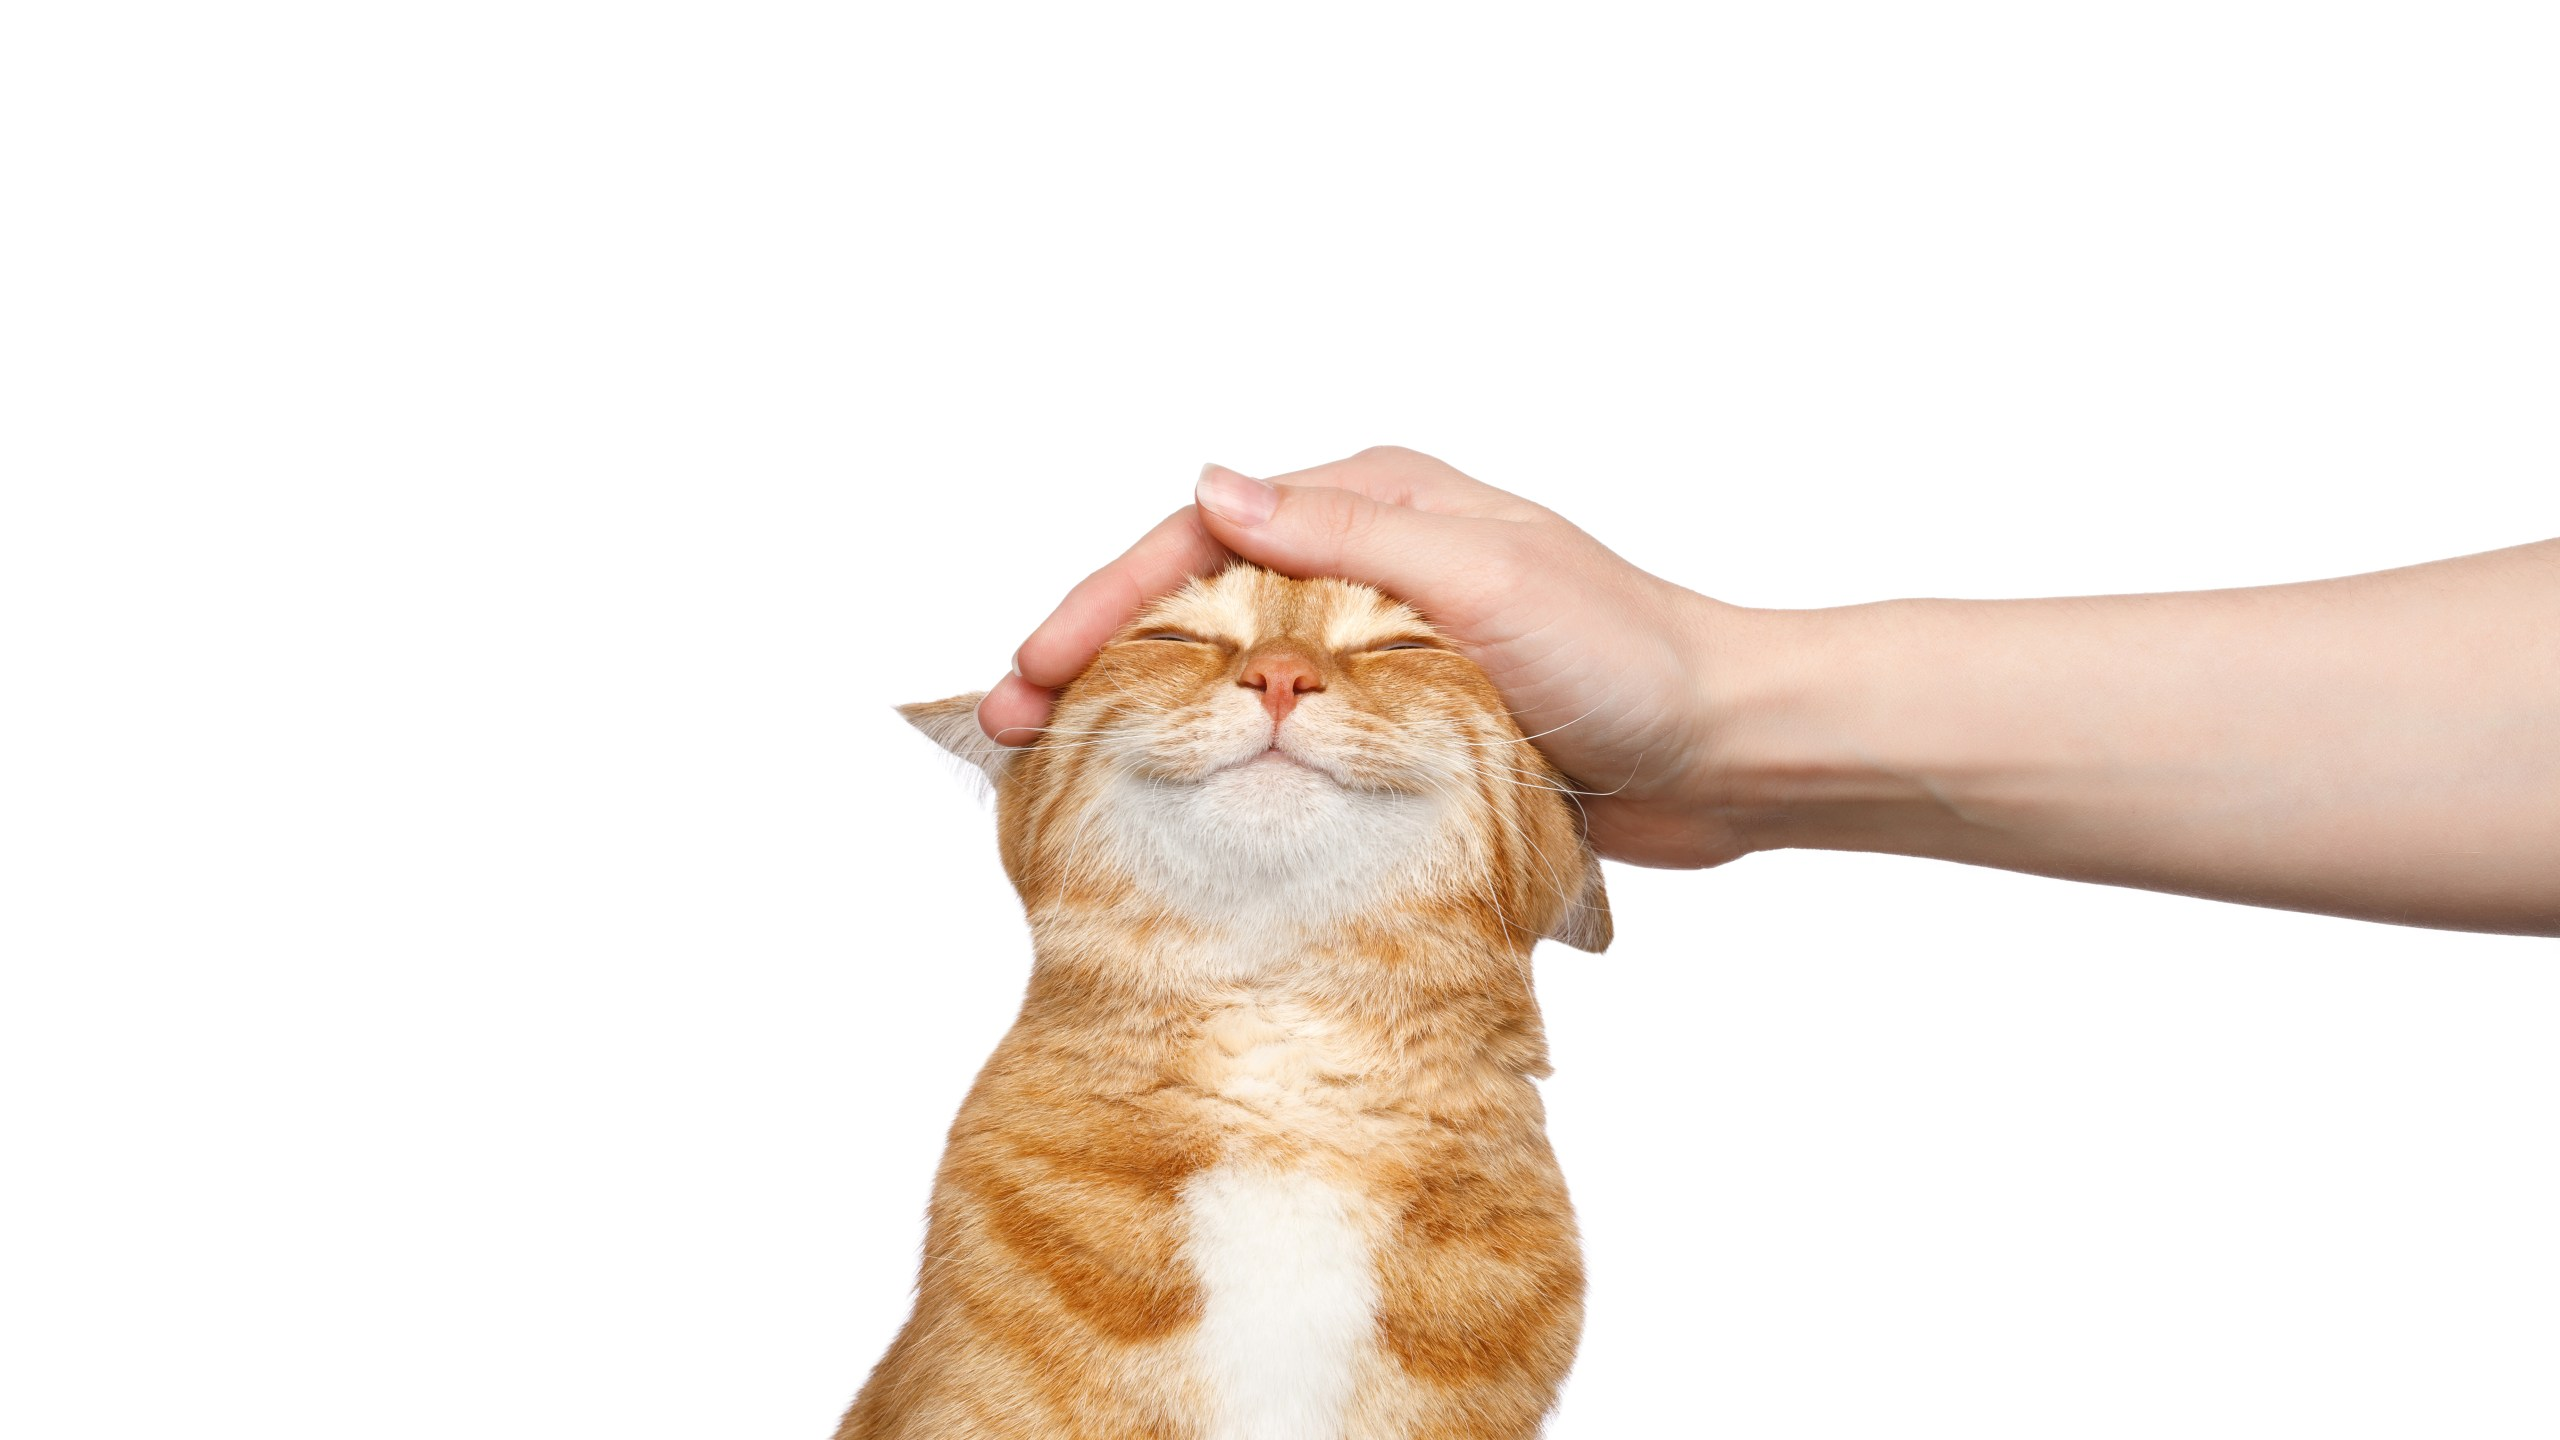

In [31]:
from PIL import Image
import requests

url = "https://www.wfla.com/wp-content/uploads/sites/71/2023/05/GettyImages-1389862392.jpg?w=2560&h=1440&crop=1"
image = Image.open(requests.get(url, stream=True).raw)
image

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

Call `generate` and decode the predictions.

In [33]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

i ' s the thing in the world.. a and a person


In [ ]:
model.save_pretrained("weights")

In [23]:
generated_caption = generated_caption.replace(" '", "'").replace("' ", "'")

In [24]:
print(len(generated_caption))

25


In [25]:
generated_caption

"i'm in love with a person"

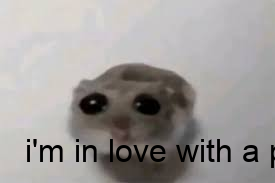

In [26]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

image = Image.open(requests.get(url, stream=True).raw)
x, y = image.size

if len(generated_caption) > 50:
    top = generated_caption[:len(generated_caption) // 2]
    bottom = generated_caption[len(generated_caption) // 2:]
else:
    top = ""
    bottom = generated_caption

draw = ImageDraw.Draw(image)
# font = ImageFont.truetype(<font-file>, <font-size>)
font = ImageFont.truetype("Arial.ttf", 32)
# draw.text((x, y),"Sample Text",(r,g,b))
draw.text((25, 50),top,(0,0,0),font=font)

draw.text((25, y-50),bottom,(0,0,0),font=font)

image.save('sample-out.jpg')
image

In [27]:
image.size

(275, 183)

```bash
a drawing of a pink and blue pokemon
```

Looks like the fine-tuned model generated a pretty good caption!